In [14]:
!git clone https://github.com/Elkkujou/Gradu.git
%cd Gradu
!ls


Cloning into 'Gradu'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 33 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 3.82 MiB | 12.91 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/Gradu/Gradu
'Financial turbulence.ipynb'   FT_source.xlsx   RF_regime.ipynb   THE_ONE.xlsx


In [15]:
#git commit -a -m "Update"
#git push

In [16]:
# Library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb

# Machine learning libraries
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


In [17]:
xls_file=pd.ExcelFile("THE_ONE.xlsx") # Read Excel
df=xls_file.parse("returns non-log")
# Flatten multi-index columns
df.columns = df.columns.get_level_values(0)

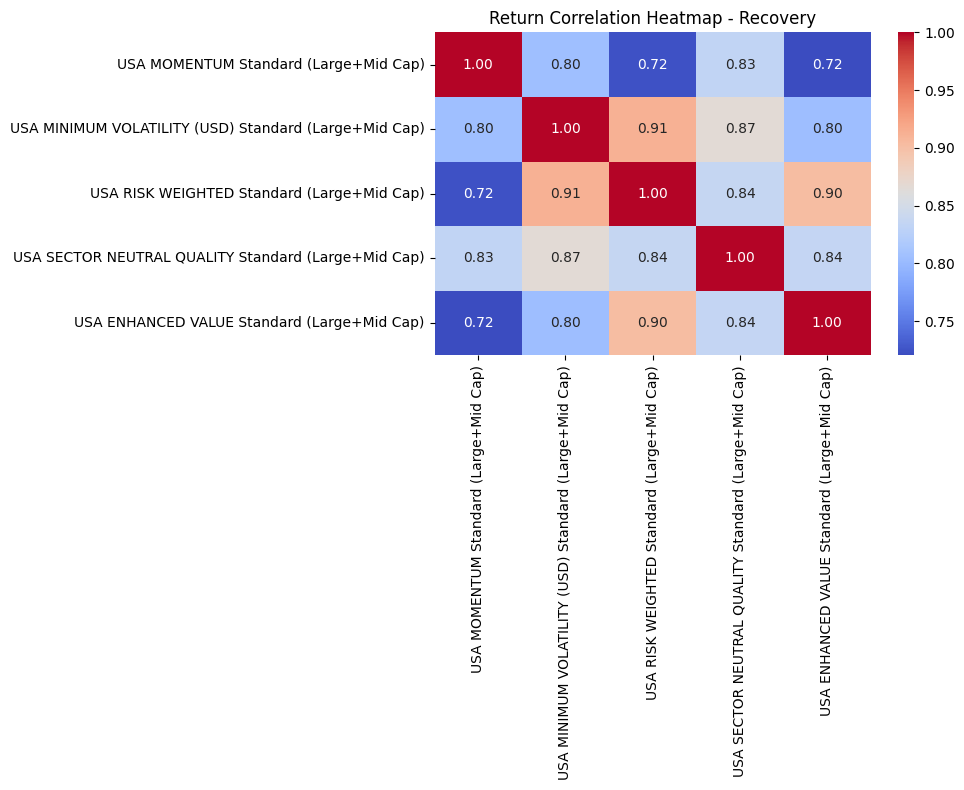

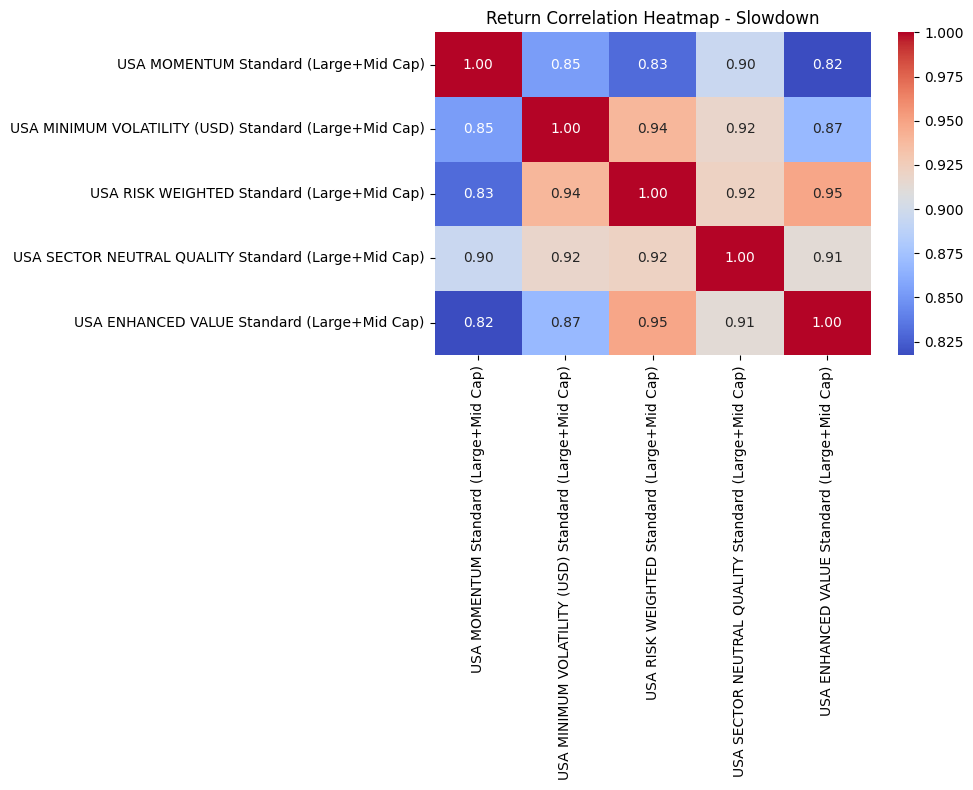

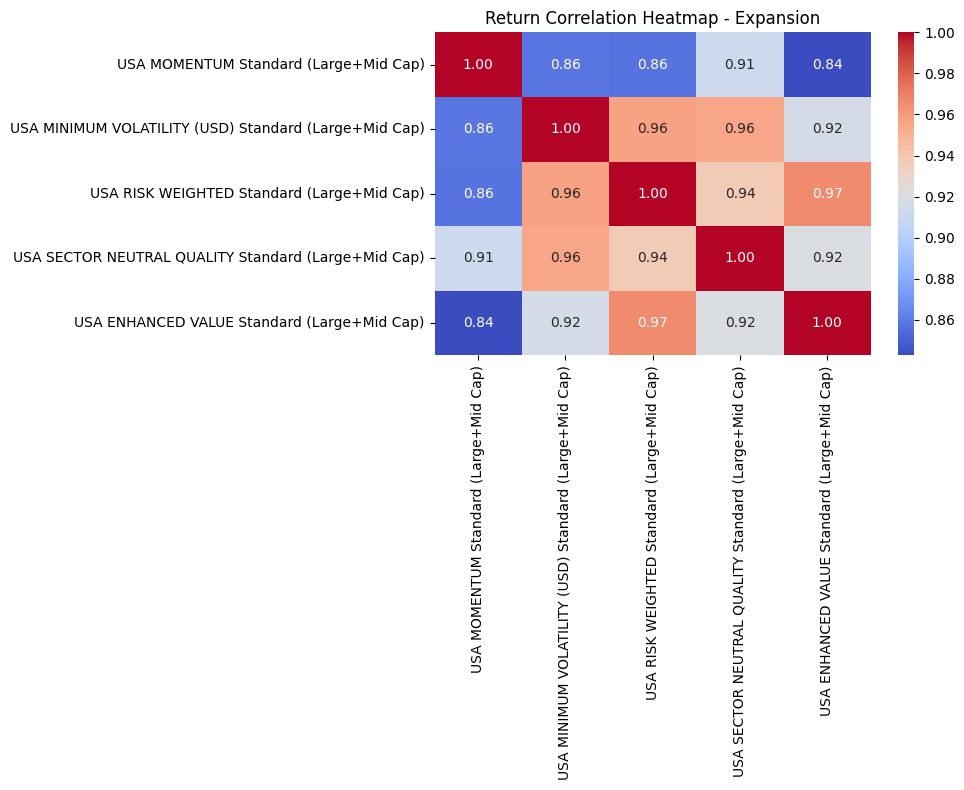

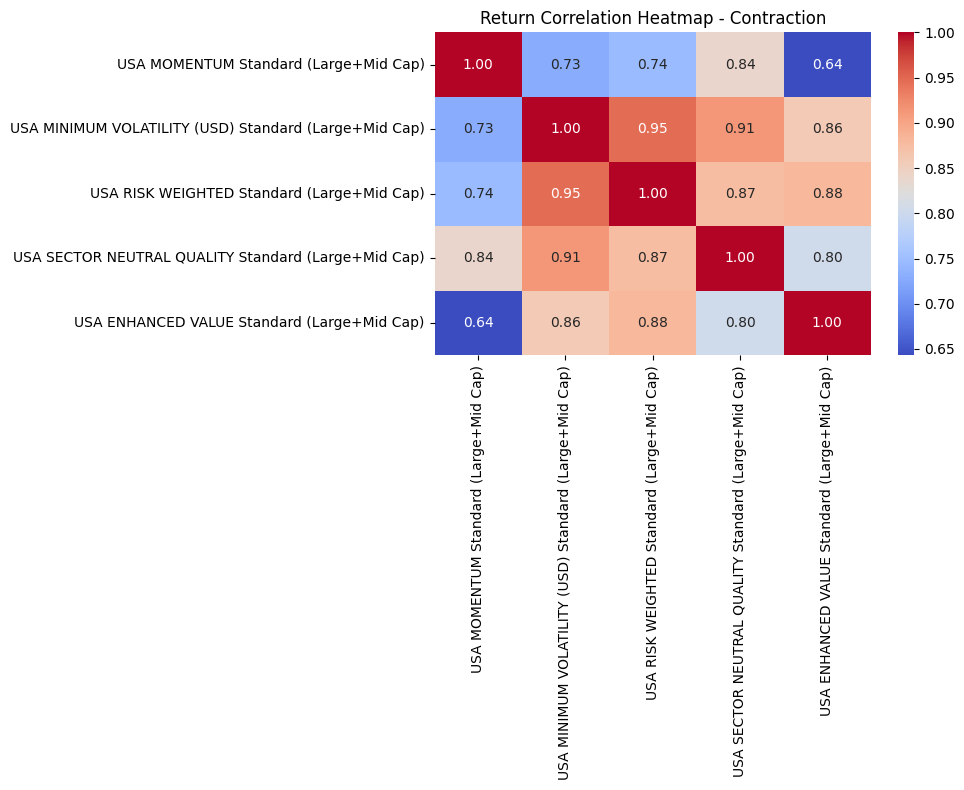

In [18]:
import seaborn as sb
import matplotlib.pyplot as plt

# Define the columns representing the returns you want to analyze
returns_columns = [
    'USA MOMENTUM Standard (Large+Mid Cap)',
    'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)',
    'USA RISK WEIGHTED Standard (Large+Mid Cap)',
    'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)',
    'USA ENHANCED VALUE Standard (Large+Mid Cap)'
]

# Compute correlations for each regime and plot heatmaps
unique_regimes = df['Regimes'].unique()

for regime in unique_regimes:
    # Filter the data for the specific regime
    regime_data = df[df['Regimes'] == regime][returns_columns]

    # Calculate the correlation matrix
    corr = regime_data.corr()

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sb.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"Return Correlation Heatmap - {regime}")
    plt.tight_layout()
    plt.show()

<Figure size 1400x800 with 0 Axes>

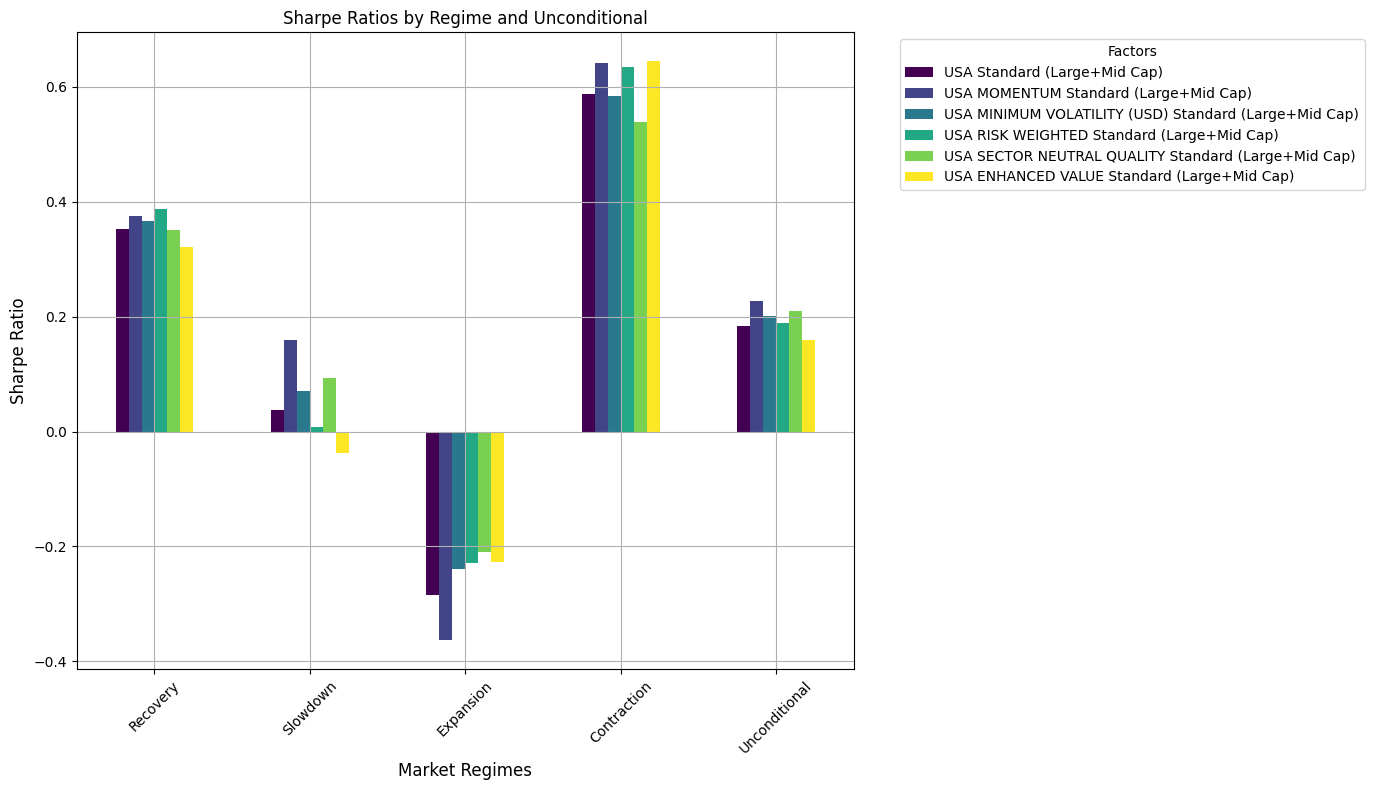

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Define factors and regime columns
factors_columns = df.columns[1:7]  # Adjust the column indices if needed
regimes_column = 'Regimes'

# Calculate Sharpe ratios by regime
sharpe_ratios = {}

unique_regimes = df[regimes_column].unique()

for regime in unique_regimes:
    regime_data = df[df[regimes_column] == regime][factors_columns]
    mean_returns = regime_data.mean()
    std_devs = regime_data.std()
    sharpe_ratios[regime] = mean_returns / std_devs

# Calculate the "Unconditional" Sharpe ratios (all data)
unconditional_mean = df[factors_columns].mean()
unconditional_std = df[factors_columns].std()
sharpe_ratios["Unconditional"] = unconditional_mean / unconditional_std

# Convert to DataFrame
sharpe_ratios_df = pd.DataFrame(sharpe_ratios).T
sharpe_ratios_df.columns = factors_columns

# Improved visualization
plt.figure(figsize=(14, 8))  # Larger figure size for readability
sharpe_ratios_df.plot(
    kind="bar",
    figsize=(14, 8),
    title="Sharpe Ratios by Regime and Unconditional",
    grid=True,
    colormap="viridis",  # Use a distinct colormap
)

# Customizing the plot
plt.ylabel("Sharpe Ratio", fontsize=12)
plt.xlabel("Market Regimes", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Factors", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.tight_layout()
plt.show()

In [20]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier


# Define valid factors
valid_factors = [
    'USA MOMENTUM Standard (Large+Mid Cap)',
    'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)',
    'USA RISK WEIGHTED Standard (Large+Mid Cap)',
    'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)',
    'USA ENHANCED VALUE Standard (Large+Mid Cap)'
]

# Filter Winning Factor to ensure it matches valid factors
df = df[df['Winning Factor'].isin(valid_factors)]
df = df.reset_index(drop=True)

# Define features and encode Regimes as numeric
df['Regimes'] = df['Regimes'].astype('category').cat.codes  # Encode regimes into numeric values

# Define features and target
X = df[['VIXCLS', 'CPI', 'LEI', '10yr', 'Financial Turbulance', 'Regimes']]
y = df['Winning Factor'].astype('category').cat.codes  # Encode Winning Factor as numeric

# Drop missing values
X = X.dropna()
y = y.loc[X.index]  # Align y with X after dropping NaNs
print(X.index.equals(y.index))  # Should return True

# Ensure dataset is sorted by date
df = df.sort_values('Date').reset_index(drop=True)

# Verify required columns
factor_columns = [
    'USA MOMENTUM Standard (Large+Mid Cap)',
    'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)',
    'USA RISK WEIGHTED Standard (Large+Mid Cap)',
    'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)',
    'USA ENHANCED VALUE Standard (Large+Mid Cap)'
]
required_columns = ['VIXCLS', 'CPI', 'LEI', '10yr', 'Financial Turbulance', 'Regimes', 'USA Standard (Large+Mid Cap)'] + factor_columns

for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

print("Parameters and dataset verified.")


True
Parameters and dataset verified.


In [21]:
# Define the percentage of data to be used for training (e.g., 67% for training, 33% for testing)
train_pct = 0.67  # Change this value to adjust training size

# Determine the last index for rolling training based on train_pct
train_end_idx = int(len(df) * train_pct)

# The final test dataset is the remaining (1 - train_pct) part
final_test_data = df.iloc[train_end_idx:]




### Random Forest Hyperparameters Table

| Hyperparameter       | Purpose                                   | Common Choices                  |
|----------------------|-------------------------------------------|---------------------------------|
| `n_estimators`      | Number of trees                           | 100 (default), 200, 500         |
| `max_depth`         | Max tree depth                            | `None` (default), 10, 20        |
| `min_samples_split` | Min samples needed to split a node       | 2 (default), 10, 20             |
| `min_samples_leaf`  | Min samples in a leaf                    | 1 (default), 5, 10              |
| `max_features`      | Features per split                       | `'sqrt'` (default), `'log2'`, `None` |
| `bootstrap`         | Use bootstrap sampling                    | `True` (default), `False`       |
| `random_state`      | Set a random seed                         | `None`, 42, 0                   |
| `criterion`         | Splitting method                          | `'gini'` (default), `'entropy'` |
| `oob_score`        | Out-of-bag validation                     | `False` (default), `True`       |
| `n_jobs`           | Parallel training                         | `None`, `-1` (all CPUs)         |


In [22]:
# Define parameters for rolling window
window_size = 120  # 10 years
step_size = 1      # 1 month

# Initialize lists for results
allocated_returns = []
probability_matrix = []
probability_dates = []
feature_importances_list = []

# Rolling window loop (only within the first train_pct of the data)
for start_idx in range(0, train_end_idx - window_size, step_size):
    # Define rolling window range
    train_idx = range(start_idx, start_idx + window_size)
    test_idx = [start_idx + window_size]

    # Split data into training and testing
    train_data = df.iloc[train_idx]
    test_data = df.iloc[test_idx]

    # Extract features and target for training
    X_train = train_data[['VIXCLS', 'CPI', 'LEI', '10yr', 'Financial Turbulance', 'Regimes']].dropna()
    y_train = train_data['Winning Factor'].astype('category').cat.codes.loc[X_train.index]
    X_test = test_data[['VIXCLS', 'CPI', 'LEI', '10yr', 'Financial Turbulance', 'Regimes']].dropna()

    # Align indices of features and target
    X_train, y_train = X_train.align(y_train, axis=0)

    # Train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Store feature importances
    feature_importances_list.append(rf_model.feature_importances_)

    # Predict probabilities for the test set
    if not X_test.empty:
        probabilities = rf_model.predict_proba(X_test)

        # Calculate portfolio return for the test instance
        portfolio_return = (probabilities * test_data[factor_columns].values).sum(axis=1)
        allocated_returns.extend(portfolio_return)

        # Store probabilities and dates
        probability_matrix.append(probabilities.flatten())
        probability_dates.append(test_data['Date'].values[0])


In [29]:
# VANHA

# Define parameters for rolling window
window_size = 120  # Example: 10 years
step_size = 1      # Example: 1 month

# Initialize lists for results
allocated_returns = []
probability_matrix = []
probability_dates = []
feature_importances_list = []  # Feature importance storage

# Rolling window loop
for start_idx in range(0, len(df) - window_size, step_size):
    # Define rolling window range
    train_idx = range(start_idx, start_idx + window_size)
    test_idx = [start_idx + window_size]

    # Split data into training and testing
    train_data = df.iloc[train_idx]
    test_data = df.iloc[test_idx]

    # Extract features and target for training
    X_train = train_data[['VIXCLS', 'CPI', 'LEI', '10yr', 'Financial Turbulance', 'Regimes']].dropna()
    y_train = train_data['Winning Factor'].astype('category').cat.codes.loc[X_train.index]
    X_test = test_data[['VIXCLS', 'CPI', 'LEI', '10yr', 'Financial Turbulance', 'Regimes']].dropna()

    # Align indices of features and target
    X_train, y_train = X_train.align(y_train, axis=0)

    # Train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Store feature importances
    feature_importances_list.append(rf_model.feature_importances_)

    # Predict probabilities for the test set
    if not X_test.empty:
        probabilities = rf_model.predict_proba(X_test)

        # Calculate portfolio return for the test instance
        portfolio_return = (probabilities * test_data[factor_columns].values).sum(axis=1)
        allocated_returns.extend(portfolio_return)

        # Store probabilities and dates
        probability_matrix.append(probabilities.flatten())
        probability_dates.append(test_data['Date'].values[0])

In [30]:
from sklearn.metrics import accuracy_score

# Ensure final test dataset has the necessary features
X_final_test = final_test_data[['VIXCLS', 'CPI', 'LEI', '10yr', 'Financial Turbulance', 'Regimes']].dropna()
y_final_test = final_test_data['Winning Factor'].astype('category').cat.codes.loc[X_final_test.index]

# Align indices
X_final_test, y_final_test = X_final_test.align(y_final_test, axis=0)

# Predict the winning factor for the final test set
if not X_final_test.empty:
    y_pred_proba = rf_model.predict_proba(X_final_test)  # Predict probabilities
    y_pred = y_pred_proba.argmax(axis=1)  # Select the factor with the highest probability

    # Compute accuracy
    accuracy = accuracy_score(y_final_test, y_pred)

    print(f"Model Accuracy on Final Test Set ({1 - train_pct:.0%} of data): {accuracy:.2%}")
else:
    print("Final test dataset is empty or misaligned.")


Model Accuracy on Final Test Set (33% of data): 96.27%


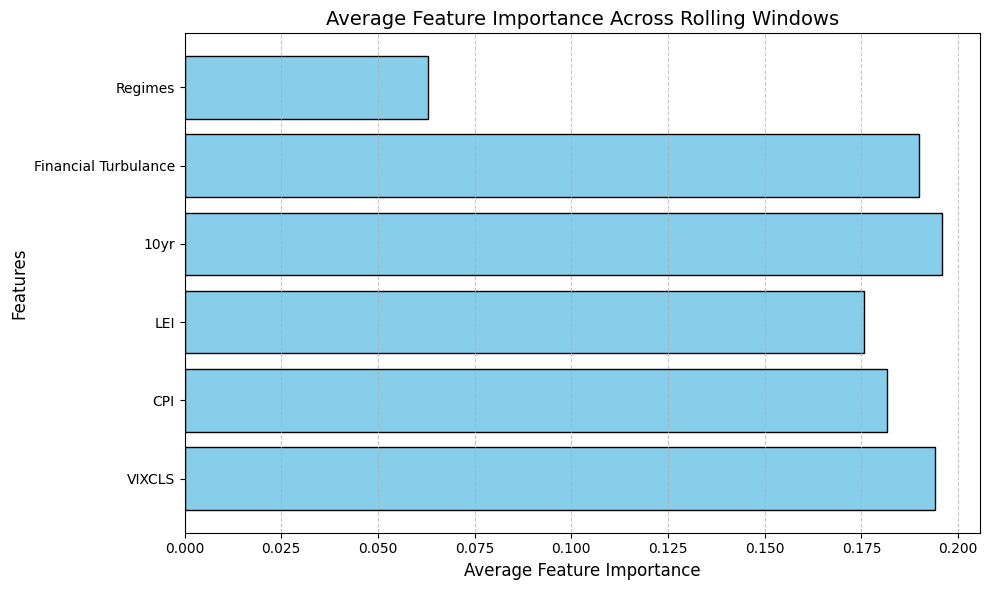

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Convert feature importance list to a NumPy array
feature_importances_array = np.array(feature_importances_list)

# Compute the average feature importance across all rolling windows
average_feature_importance = feature_importances_array.mean(axis=0)

# Define feature names for better readability
feature_names = ['VIXCLS', 'CPI', 'LEI', '10yr', 'Financial Turbulance', 'Regimes']

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_names, average_feature_importance, color='skyblue', edgecolor='black')
plt.xlabel("Average Feature Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Average Feature Importance Across Rolling Windows", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [32]:
# Convert probabilities to DataFrame
probability_df = pd.DataFrame(
    probability_matrix,
    columns=factor_columns
)

# Add the corresponding dates
probability_df['Date'] = probability_dates

# Ensure sorting by date
probability_df = probability_df.sort_values("Date").reset_index(drop=True)

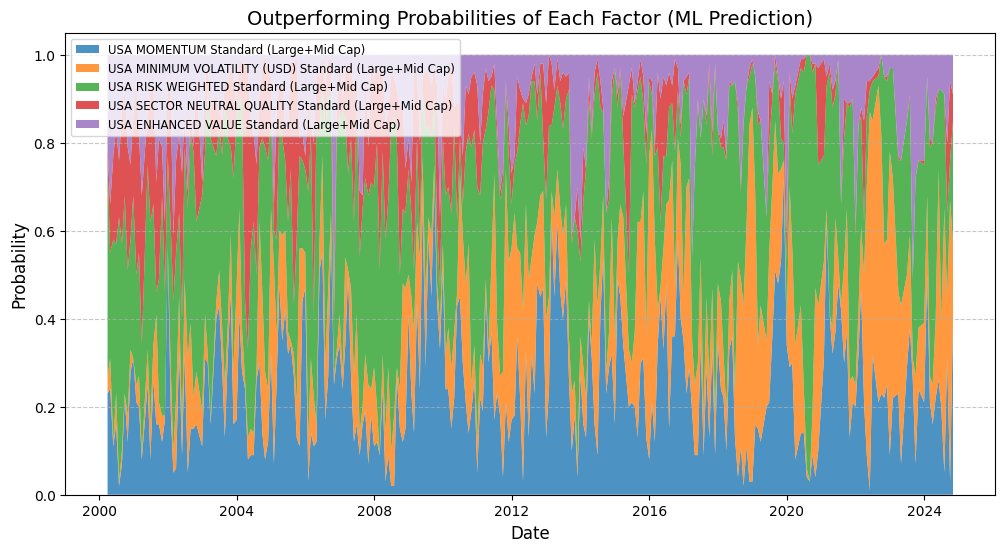

In [33]:
import matplotlib.pyplot as plt

# Create a stacked area chart
plt.figure(figsize=(12, 6))
plt.stackplot(
    probability_df['Date'],
    probability_df[factor_columns[0]],
    probability_df[factor_columns[1]],
    probability_df[factor_columns[2]],
    probability_df[factor_columns[3]],
    probability_df[factor_columns[4]],
    labels=factor_columns,
    alpha=0.8
)

# Customize visualization
plt.title("Outperforming Probabilities of Each Factor (ML Prediction)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.legend(loc='upper left', fontsize='small')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [34]:
# Compute portfolio returns using predicted probabilities as weights
strategy_returns = (probability_df[factor_columns].values * df.loc[window_size:, factor_columns].values).sum(axis=1)

# Convert to NumPy array
strategy_returns = np.array(strategy_returns)

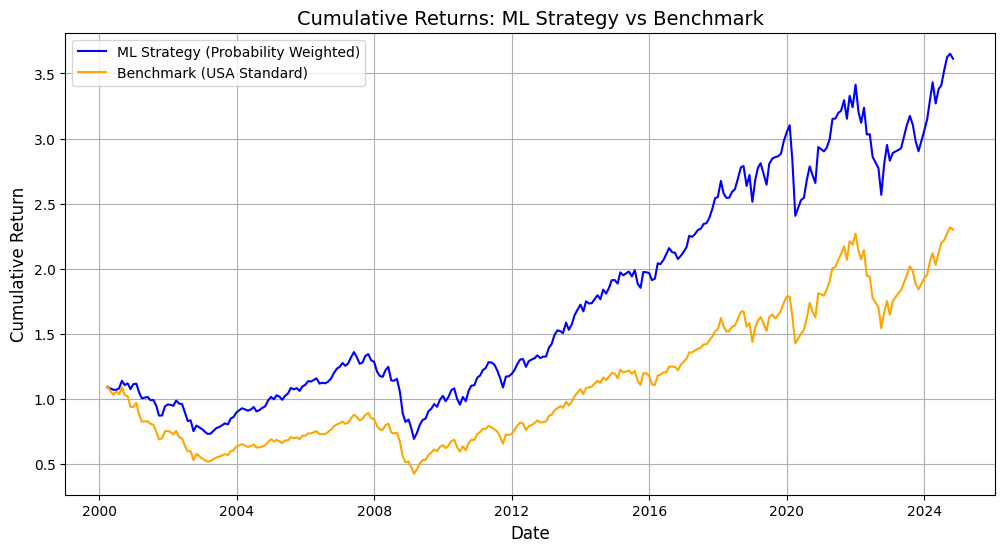

In [35]:
# Extract benchmark returns
benchmark_returns = df.iloc[window_size:]['USA Standard (Large+Mid Cap)'].values[:len(strategy_returns)]

# Compute cumulative returns
cumulative_strategy = (1 + strategy_returns).cumprod()
cumulative_benchmark = (1 + benchmark_returns).cumprod()

# Plot cumulative performance comparison
plt.figure(figsize=(12, 6))
plt.plot(df.loc[window_size:, 'Date'][:len(cumulative_strategy)], cumulative_strategy, label="ML Strategy (Probability Weighted)", color="blue")
plt.plot(df.loc[window_size:, 'Date'][:len(cumulative_benchmark)], cumulative_benchmark, label="Benchmark (USA Standard)", color="orange")

# Customize the visualization
plt.title("Cumulative Returns: ML Strategy vs Benchmark", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend()
plt.grid()
plt.show()

In [36]:
# Define metric calculation functions
def annualized_return(returns):
    return np.prod(1 + returns)**(12 / len(returns)) - 1

def annualized_volatility(returns):
    return np.std(returns) * np.sqrt(12)

def sharpe_ratio(returns):
    return annualized_return(returns) / annualized_volatility(returns)

def tracking_error(strategy_returns, benchmark_returns):
    return np.std(strategy_returns - benchmark_returns) * np.sqrt(12)

def information_ratio(strategy_returns, benchmark_returns):
    excess_returns = annualized_return(strategy_returns) - annualized_return(benchmark_returns)
    return excess_returns / tracking_error(strategy_returns, benchmark_returns)

# Ensure strategy_returns and benchmark_returns are numpy arrays
strategy_returns = np.array(strategy_returns)  # Use your strategy returns from the previous calculations
benchmark_returns = np.array(benchmark_returns)  # Your benchmark returns

# Calculate metrics for ML Strategy
ml_annualized_return = annualized_return(strategy_returns)
ml_annualized_volatility = annualized_volatility(strategy_returns)
ml_sharpe_ratio = sharpe_ratio(strategy_returns)
ml_tracking_error = tracking_error(strategy_returns, benchmark_returns)
ml_information_ratio = information_ratio(strategy_returns, benchmark_returns)

# Calculate metrics for Benchmark
benchmark_annualized_return = annualized_return(benchmark_returns)
benchmark_annualized_volatility = annualized_volatility(benchmark_returns)
benchmark_sharpe_ratio = sharpe_ratio(benchmark_returns)

# Create the performance metrics table
metrics_table = pd.DataFrame({
    "Metric": [
        "Annualized Return",
        "Annualized Volatility",
        "Sharpe Ratio",
        "Tracking Error",
        "Information Ratio"
    ],
    "ML Strategy": [
        f"{ml_annualized_return*100:.2f}%",
        f"{ml_annualized_volatility*100:.2f}%",
        f"{ml_sharpe_ratio:.6f}",
        f"{ml_tracking_error*100:.2f}%",
        f"{ml_information_ratio:.2f}"
    ],
    "Benchmark": [
        f"{benchmark_annualized_return*100:.2f}%",
        f"{benchmark_annualized_volatility*100:.2f}%",
        f"{benchmark_sharpe_ratio:.6f}",
        "nan%",
        "nan"
    ]
})

# Print the table
print(metrics_table.to_string(index=False))

               Metric ML Strategy Benchmark
    Annualized Return       5.56%     3.57%
Annualized Volatility      13.48%    15.05%
         Sharpe Ratio    0.412432  0.237292
       Tracking Error       4.10%      nan%
    Information Ratio        0.49       nan


In [37]:
import statsmodels.api as sm

# Create DataFrame for regression
regression_data = pd.DataFrame({
    'Strategy': strategy_returns,
    'Benchmark': benchmark_returns
}).dropna()  # Drop NaN values

# Define independent (X) and dependent (y) variables
X = regression_data['Benchmark']  # Benchmark as independent variable
y = regression_data['Strategy']   # Strategy as dependent variable

# Add a constant (intercept)
X = sm.add_constant(X)

# Run OLS regression
model = sm.OLS(y, X).fit()

# Display regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Strategy   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     3795.
Date:                Sat, 01 Feb 2025   Prob (F-statistic):          5.58e-166
Time:                        11:44:03   Log-Likelihood:                 901.09
No. Observations:                 285   AIC:                            -1798.
Df Residuals:                     283   BIC:                            -1791.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.155      0.0